## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

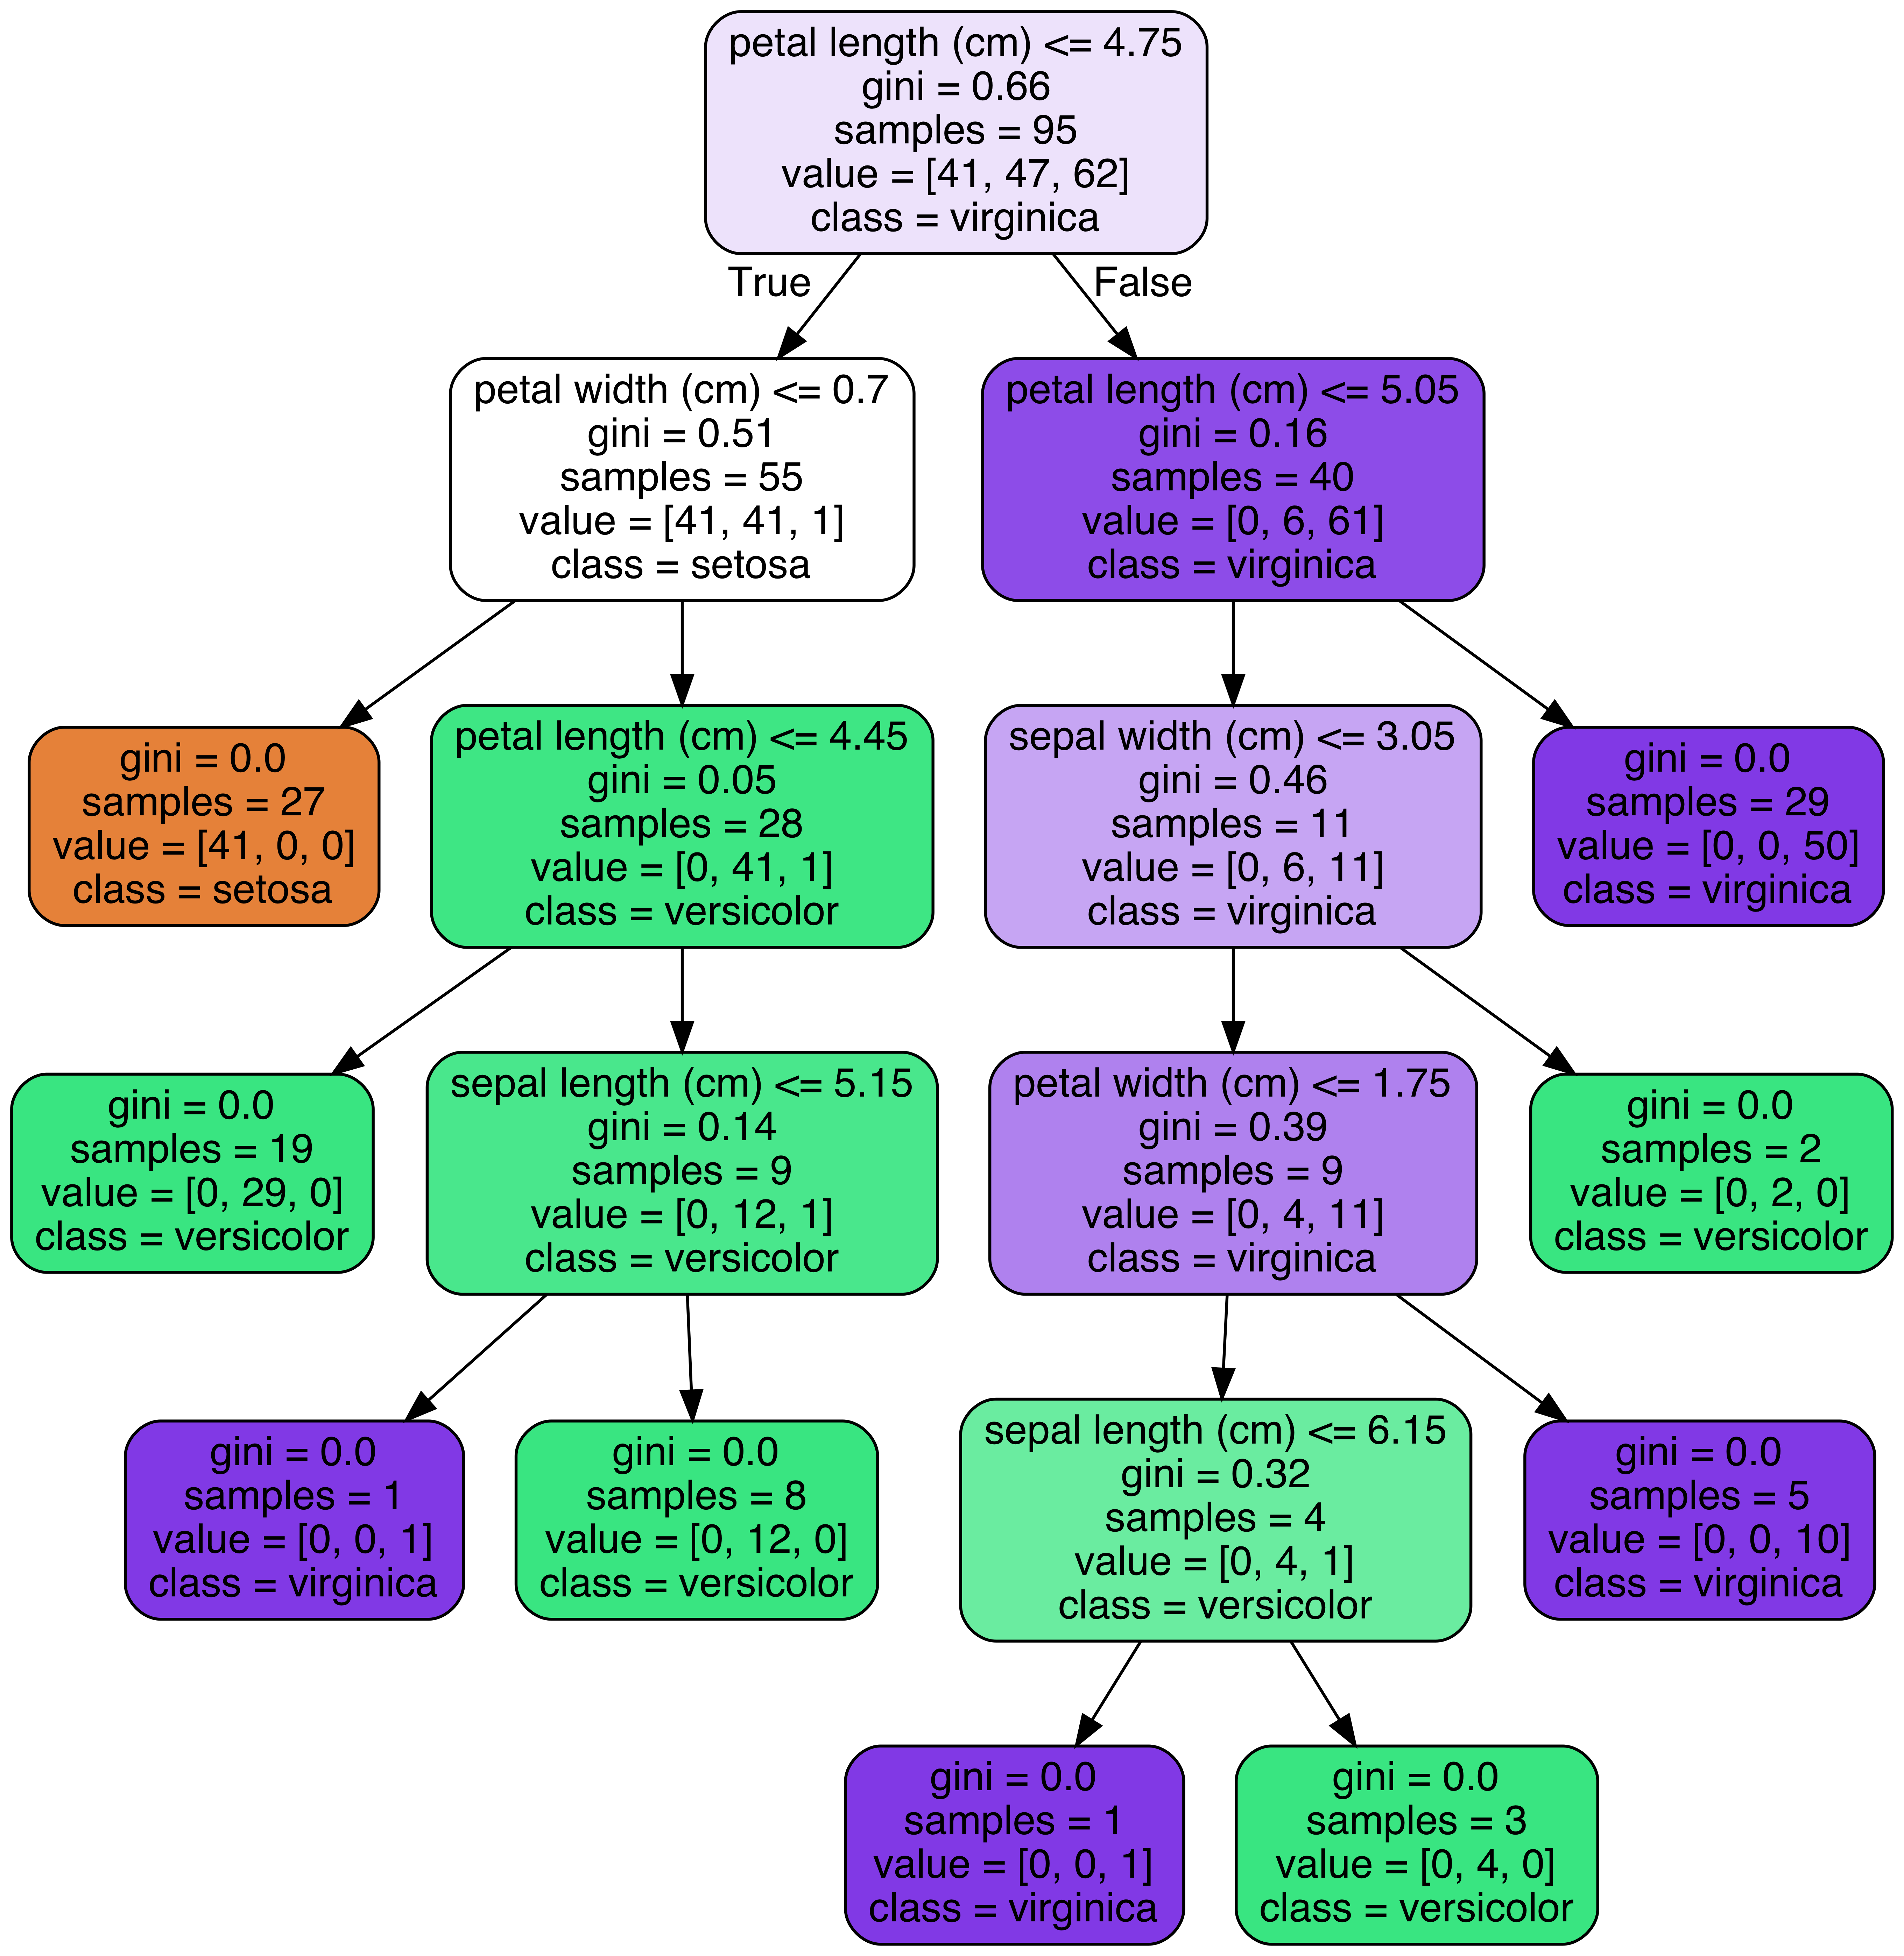

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [3]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from datetime import date

In [4]:
url ='PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [5]:
df.shape

(2218, 18)

In [6]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [7]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [8]:
df['year'] = pd.DatetimeIndex(df['birth_year']).year
today = date.today()
#print(today.year)
for i in df['patient_id']:
    df['n_age'] = today.year - df['birth_year']
    

df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,year,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,1970.0,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,1970.0,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,1970.0,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,1970.0,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,1970.0,28.0


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [9]:
missing_values = df.isna().sum() 
missing_value_df = pd.DataFrame({'missing_values': missing_values})
missing_value_df

,missing_values
patient_id,0
global_num,904
sex,145
birth_year,454
age,261
country,0
province,0
city,65
disease,2199
infection_case,1055


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 20 columns):
patient_id            2218 non-null int64
global_num            1314 non-null float64
sex                   2073 non-null object
birth_year            1764 non-null float64
age                   1957 non-null object
country               2218 non-null object
province              2218 non-null object
city                  2153 non-null object
disease               19 non-null object
infection_case        1163 non-null object
infection_order       42 non-null float64
infected_by           469 non-null float64
contact_number        411 non-null float64
symptom_onset_date    193 non-null object
confirmed_date        2077 non-null object
released_date         223 non-null object
deceased_date         32 non-null object
state                 2130 non-null object
year                  1764 non-null float64
n_age                 1764 non-null float64
dtypes: float64(7), int64(1), object(

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [11]:
df['disease'].replace(np.nan, 0, inplace=True)
df['disease'].map({True: 1})

df['disease'].value_counts()


0       2199
True      19
Name: disease, dtype: int64

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [12]:
df['global_num'].fillna((df['global_num'].mean()), inplace=True)
df['birth_year'].fillna((df['birth_year'].mean()), inplace=True)
df['infection_order'].fillna((df['infection_order'].mean()), inplace=True)
df['infected_by'].fillna((df['infected_by'].mean()), inplace=True)
df['contact_number'].fillna((df['contact_number'].mean()), inplace=True)
df

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,year,n_age
0,1000000001,2.000000,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.000000,2.600789e+09,75.000000,2020-01-22,2020-01-23,2020-02-05,NaN,released,1970.0,56.0
1,1000000002,5.000000,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.000000,2.600789e+09,31.000000,NaN,2020-01-30,2020-03-02,NaN,released,1970.0,33.0
2,1000000003,6.000000,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.000000,2.002000e+09,17.000000,NaN,2020-01-30,2020-02-19,NaN,released,1970.0,56.0
3,1000000004,7.000000,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.000000,2.600789e+09,9.000000,2020-01-26,2020-01-30,2020-02-15,NaN,released,1970.0,29.0
4,1000000005,9.000000,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.000000,1.000000e+09,2.000000,NaN,2020-01-31,2020-02-24,NaN,released,1970.0,28.0
5,1000000006,10.000000,female,1966.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,3.000000,1.000000e+09,43.000000,NaN,2020-01-31,2020-02-19,NaN,released,1970.0,54.0
6,1000000007,11.000000,male,1995.0,20s,Korea,Seoul,Jongno-gu,0,contact with patient,3.000000,1.000000e+09,0.000000,NaN,2020-01-31,2020-02-10,NaN,released,1970.0,25.0
7,1000000008,13.000000,male,1992.0,20s,Korea,Seoul,etc,0,overseas inflow,1.000000,2.600789e+09,0.000000,NaN,2020-02-02,2020-02-24,NaN,released,1970.0,28.0
8,1000000009,19.000000,male,1983.0,30s,Korea,Seoul,Songpa-gu,0,overseas inflow,2.000000,2.600789e+09,68.000000,NaN,2020-02-05,2020-02-21,NaN,released,1970.0,37.0
9,1000000010,21.000000,female,1960.0,60s,Korea,Seoul,Seongbuk-gu,0,contact with patient,3.000000,1.000000e+09,6.000000,NaN,2020-02-05,2020-02-29,NaN,released,1970.0,60.0


 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [13]:
df=df.fillna(method ='pad') 
df

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,year,n_age
0,1000000001,2.000000,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.000000,2.600789e+09,75.000000,2020-01-22,2020-01-23,2020-02-05,NaN,released,1970.0,56.0
1,1000000002,5.000000,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.000000,2.600789e+09,31.000000,2020-01-22,2020-01-30,2020-03-02,NaN,released,1970.0,33.0
2,1000000003,6.000000,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.000000,2.002000e+09,17.000000,2020-01-22,2020-01-30,2020-02-19,NaN,released,1970.0,56.0
3,1000000004,7.000000,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.000000,2.600789e+09,9.000000,2020-01-26,2020-01-30,2020-02-15,NaN,released,1970.0,29.0
4,1000000005,9.000000,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.000000,1.000000e+09,2.000000,2020-01-26,2020-01-31,2020-02-24,NaN,released,1970.0,28.0
5,1000000006,10.000000,female,1966.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,3.000000,1.000000e+09,43.000000,2020-01-26,2020-01-31,2020-02-19,NaN,released,1970.0,54.0
6,1000000007,11.000000,male,1995.0,20s,Korea,Seoul,Jongno-gu,0,contact with patient,3.000000,1.000000e+09,0.000000,2020-01-26,2020-01-31,2020-02-10,NaN,released,1970.0,25.0
7,1000000008,13.000000,male,1992.0,20s,Korea,Seoul,etc,0,overseas inflow,1.000000,2.600789e+09,0.000000,2020-01-26,2020-02-02,2020-02-24,NaN,released,1970.0,28.0
8,1000000009,19.000000,male,1983.0,30s,Korea,Seoul,Songpa-gu,0,overseas inflow,2.000000,2.600789e+09,68.000000,2020-01-26,2020-02-05,2020-02-21,NaN,released,1970.0,37.0
9,1000000010,21.000000,female,1960.0,60s,Korea,Seoul,Seongbuk-gu,0,contact with patient,3.000000,1.000000e+09,6.000000,2020-01-26,2020-02-05,2020-02-29,NaN,released,1970.0,60.0


In [14]:
df.isnull().sum()

patient_id              0
global_num              0
sex                     0
birth_year              0
age                     0
country                 0
province                0
city                    0
disease                 0
infection_case          0
infection_order         0
infected_by             0
contact_number          0
symptom_onset_date      0
confirmed_date          0
released_date           0
deceased_date         109
state                   0
year                    0
n_age                   0
dtype: int64

 **<font color='teal'> Check for any remaining null values.</font>**

In [15]:
df.isna().sum()

patient_id              0
global_num              0
sex                     0
birth_year              0
age                     0
country                 0
province                0
city                    0
disease                 0
infection_case          0
infection_order         0
infected_by             0
contact_number          0
symptom_onset_date      0
confirmed_date          0
released_date           0
deceased_date         109
state                   0
year                    0
n_age                   0
dtype: int64

In [16]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,year,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,1970.0,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,2020-01-22,2020-01-30,2020-03-02,NaN,released,1970.0,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,2020-01-22,2020-01-30,2020-02-19,NaN,released,1970.0,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,1970.0,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,2020-01-26,2020-01-31,2020-02-24,NaN,released,1970.0,28.0


Remove date columns from the data.


In [17]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [18]:
print(df.nunique())

patient_id         2218
global_num         1304
sex                   2
birth_year           97
age                  11
country               4
province             17
city                134
disease               2
infection_case       16
infection_order       7
infected_by         207
contact_number       73
state                 3
year                  1
n_age                96
dtype: int64


Review the percent of unique values by column.

In [19]:
print(df.nunique()/df.shape[0] * 100)

patient_id         100.000000
global_num          58.791704
sex                  0.090171
birth_year           4.373309
age                  0.495942
country              0.180343
province             0.766456
city                 6.041479
disease              0.090171
infection_case       0.721371
infection_order      0.315600
infected_by          9.332732
contact_number       3.291253
state                0.135257
year                 0.045086
n_age                4.328224
dtype: float64


Review the range of values per column.

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664817e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.664817e+03,5.900250e+03,8.717000e+03
birth_year,2218.0,1.974989e+03,1.731123e+01,1.916000e+03,1.965000e+03,1.974989e+03,1.988000e+03,2.020000e+03
infection_order,2218.0,2.285714e+00,1.706622e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
year,2218.0,1.970000e+03,0.000000e+00,1.970000e+03,1.970000e+03,1.970000e+03,1.970000e+03,1.970000e+03
n_age,2218.0,4.793733e+01,1.950689e+01,0.000000e+00,3.100000e+01,5.100000e+01,6.200000e+01,1.040000e+02


### Check for duplicated rows

In [21]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,year,n_age


Print the categorical columns and their associated levels.

In [22]:

dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,age,11
2,country,4
3,province,17
4,city,134
5,disease,2
6,infection_case,16
7,state,3


In [23]:
dfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 8 columns):
sex               2218 non-null object
age               2218 non-null object
country           2218 non-null object
province          2218 non-null object
city              2218 non-null object
disease           2218 non-null object
infection_case    2218 non-null object
state             2218 non-null object
dtypes: object(8)
memory usage: 138.7+ KB


**<font color='teal'> Plot the correlation heat map for the features.</font>**

In [24]:
dfo.head(10)

,sex,age,country,province,city,disease,infection_case,state
0,male,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,released
1,male,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,released
2,male,50s,Korea,Seoul,Jongno-gu,0,contact with patient,released
3,male,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,released
4,female,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,released
5,female,50s,Korea,Seoul,Jongno-gu,0,contact with patient,released
6,male,20s,Korea,Seoul,Jongno-gu,0,contact with patient,released
7,male,20s,Korea,Seoul,etc,0,overseas inflow,released
8,male,30s,Korea,Seoul,Songpa-gu,0,overseas inflow,released
9,female,60s,Korea,Seoul,Seongbuk-gu,0,contact with patient,released


In [25]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

dfo['sex_num']=le.fit_transform(dfo['sex'])
dfo['age_num']=le.fit_transform(dfo['age'])
dfo['country_num']=le.fit_transform(dfo['country'])
dfo['province_num']=le.fit_transform(dfo['province'])
dfo['city_num']=le.fit_transform(dfo['city'])
dfo['disease_num']=le.fit_transform(dfo['disease'])
dfo['infection_case_num']=le.fit_transform(dfo['infection_case'])
dfo['state_num']=le.fit_transform(dfo['state'])

/Users/ssob/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/ssob/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/ssob/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [26]:
dfo.head(10)

,sex,age,country,province,city,disease,infection_case,state,sex_num,age_num,country_num,province_num,city_num,disease_num,infection_case_num,state_num
0,male,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,released,1,6,1,15,34,0,15,2
1,male,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,released,1,4,1,15,76,0,15,2
2,male,50s,Korea,Seoul,Jongno-gu,0,contact with patient,released,1,6,1,15,74,0,11,2
3,male,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,released,1,3,1,15,77,0,15,2
4,female,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,released,0,3,1,15,99,0,11,2
5,female,50s,Korea,Seoul,Jongno-gu,0,contact with patient,released,0,6,1,15,74,0,11,2
6,male,20s,Korea,Seoul,Jongno-gu,0,contact with patient,released,1,3,1,15,74,0,11,2
7,male,20s,Korea,Seoul,etc,0,overseas inflow,released,1,3,1,15,132,0,15,2
8,male,30s,Korea,Seoul,Songpa-gu,0,overseas inflow,released,1,4,1,15,106,0,15,2
9,female,60s,Korea,Seoul,Seongbuk-gu,0,contact with patient,released,0,7,1,15,99,0,11,2


In [27]:
dfo_corr_df = dfo[['sex_num','age_num','country_num','province_num','city_num','disease_num','infection_case_num','state_num']]

In [28]:
dfo_corr_df.head(10)

,sex_num,age_num,country_num,province_num,city_num,disease_num,infection_case_num,state_num
0,1,6,1,15,34,0,15,2
1,1,4,1,15,76,0,15,2
2,1,6,1,15,74,0,11,2
3,1,3,1,15,77,0,15,2
4,0,3,1,15,99,0,11,2
5,0,6,1,15,74,0,11,2
6,1,3,1,15,74,0,11,2
7,1,3,1,15,132,0,15,2
8,1,4,1,15,106,0,15,2
9,0,7,1,15,99,0,11,2


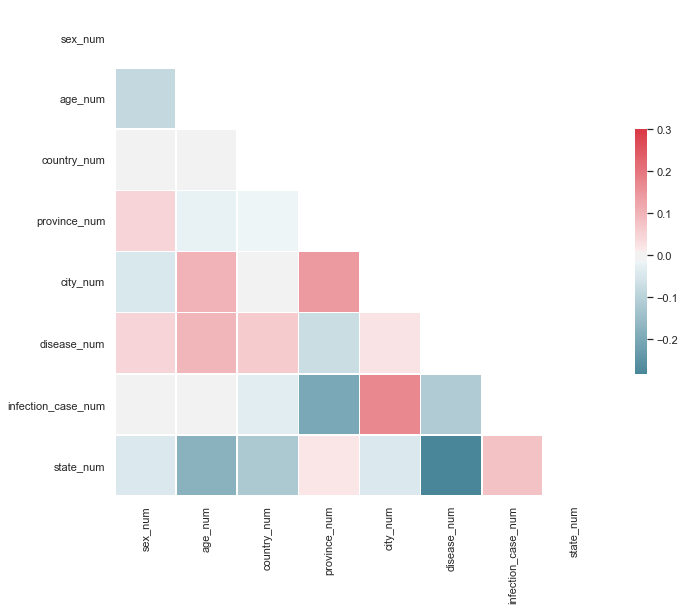

In [29]:
import numpy as np
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v

sns.set(style="white")

dfo = dfo_corr_df.dropna()
corr = dfo.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

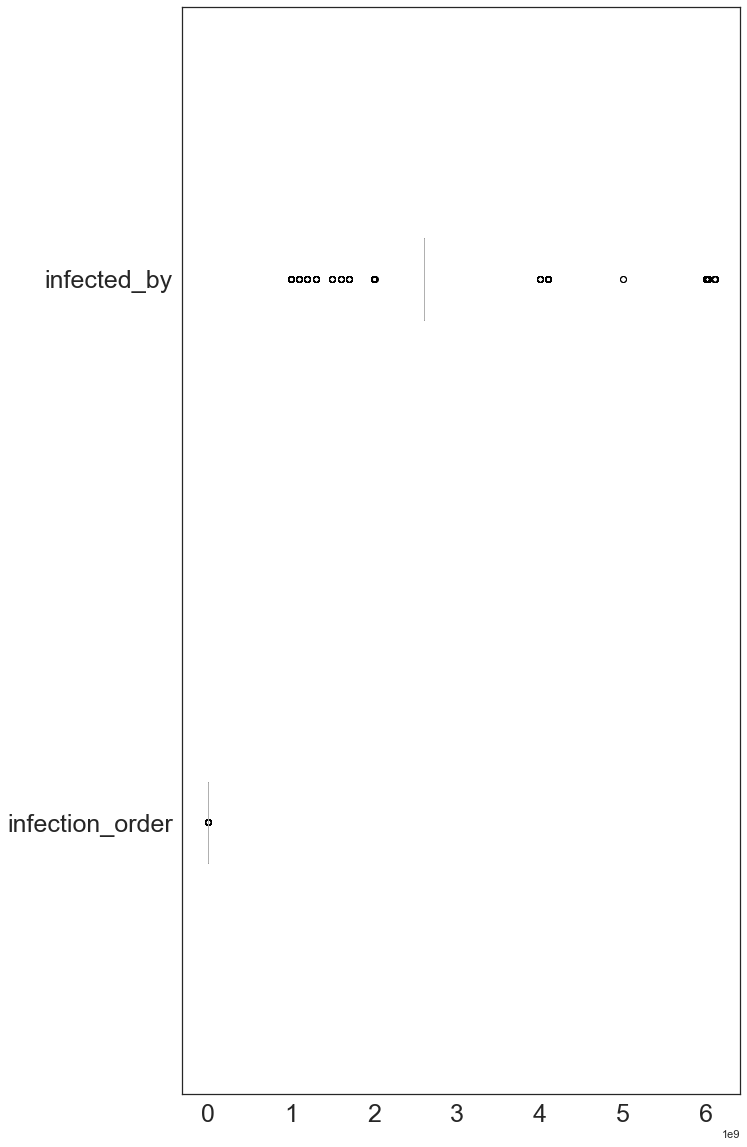

In [37]:

df_new = df[["infection_order","infected_by"]]
df_new.boxplot(grid=False, vert=False,fontsize=25, figsize=(10,20))


In [ ]:
Q1 = df_new.quantile(0.25)
Q3 = df_new.quantile(0.75)
IQR = Q3 - Q1
IQR

In [ ]:
#dfno = df_new[~((df_new < (Q1 - 1.5 * IQR)) |(df_new> (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
#df_box = dfno.boxplot(grid=False, vert=False,fontsize=15, figsize=(10,10))

**<font color='teal'> Create dummy features for object type features. </font>**

In [38]:

#X = df.drop(['state','country'],axis = 1)
#y = df['state']

### Split the data into test and train subsamples

In [ ]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [ ]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [ ]:
class_names=['isolated','released','missing','deceased'] # name  of classes

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

In [ ]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.